## Example: PCS use case

This notebook shows all the steps to generate PCS KG and the downstream analysis.

## Install packages

In [1]:
import os

os.chdir("../../../")
!pwd

/Users/yojana/Documents/GitHub/pyBiodatafuse


In [2]:
# Import modules
import pickle

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

from pyBiodatafuse import id_mapper
from pyBiodatafuse.annotators import disgenet, minerva, opentargets, stringdb
from pyBiodatafuse.constants import (
    DISGENET_DISEASE_COL,
    LITERATURE_DISEASE_COL,
    LITERATURE_DISEASE_OUTPUT_DICT,
)
from pyBiodatafuse.graph import generator
from pyBiodatafuse.utils import (
    combine_sources,
    create_harmonized_input_file,
    create_or_append_to_metadata,
)

## Load input genes

In [3]:
data_input = pd.read_csv(os.path.join(os.getcwd(), r"examples/usecases/PCS/data/PCS_gene_list.csv"))
print("Total number of genes:", len(data_input.drop_duplicates()))
data_input.head()

Total number of genes: 2023


,identifier
0,LOC729609
1,LOC105374060
2,DMP1
3,PNLIP
4,OR4N3P


### Entity resolution using BridgeDB

In [4]:
pickle_path = os.path.join(os.getcwd(), "examples/usecases/PCS/data/PCS_gene_list.pkl")
metadata_path = os.path.join(os.getcwd(), "examples/usecases/PCS/data/PCS_gene_list_metadata.pkl")

if not os.path.exists(pickle_path):
    bridgedb_df, bridgedb_metadata = id_mapper.bridgedb_xref(
        identifiers=data_input,
        input_species="Human",
        input_datasource="HGNC",
        output_datasource="All",
    )
    bridgedb_df.to_pickle(pickle_path)
    with open(metadata_path, "wb") as file:
        pickle.dump(bridgedb_metadata, file)
else:
    bridgedb_df = pd.read_pickle(pickle_path)
    with open(metadata_path, "rb") as file:
        bridgedb_metadata = pickle.load(file)

In [5]:
print("Number of genes with mapping in BridgeDb:", len(bridgedb_df["identifier"].unique()))
bridgedb_df.head()

Number of genes with mapping in BridgeDb: 1667


,identifier,identifier.source,target,target.source
0,DMP1,HGNC,Q13316,Uniprot-TrEMBL
1,DMP1,HGNC,HGNC:2932,HGNC Accession Number
2,DMP1,HGNC,DMP1,HGNC
3,DMP1,HGNC,ENSG00000152592,Ensembl
4,DMP1,HGNC,1758,NCBI Gene


## Step-by-step graph generation based on data source of interest


### Gene-Disease edges

Here we use Disgenet database. To run the following code, you would need the API key from DisGeNet by creating an account [here](https://disgenet.com/Profile-area#apiKey)

In [6]:
disgenet_api_key = "REPLACE_WITH_YOUR_DISGENET_API_KEY"

In [7]:
disgenet_pickle_path = os.path.join(os.getcwd(), "examples/usecases/PCS/data/disgenet_df.pkl")
disgenet_metadata_path = os.path.join(
    os.getcwd(), "examples/usecases/PCS/data/disgenet_metadata.pkl"
)

if not os.path.exists(disgenet_pickle_path):
    disgenet_df, disgenet_metadata = disgenet.get_gene_disease(
        api_key=disgenet_api_key, bridgedb_df=bridgedb_df
    )
    disgenet_df.to_pickle(disgenet_pickle_path)
    with open(disgenet_metadata_path, "wb") as file:
        pickle.dump(disgenet_metadata, file)
else:
    disgenet_df = pd.read_pickle(disgenet_pickle_path)
    with open(disgenet_metadata_path, "rb") as file:
        disgenet_metadata = pickle.load(file)

disgenet_df.head()

,identifier,identifier.source,target,target.source,DISGENET_diseases
0,A2ML1,HGNC,144568,NCBI Gene,"[{'disease_name': 'Noonan Syndrome', 'HPO': No..."
1,AAMDC,HGNC,28971,NCBI Gene,"[{'disease_name': nan, 'HPO': nan, 'NCI': nan,..."
2,ABCA1,HGNC,19,NCBI Gene,"[{'disease_name': 'Tangier Disease', 'HPO': No..."
3,ABCB1,HGNC,5243,NCBI Gene,"[{'disease_name': 'Epilepsies', 'HPO': 'HPO:HP..."
4,ABCC6P1,HGNC,653190,NCBI Gene,"[{'disease_name': nan, 'HPO': nan, 'NCI': nan,..."


In [8]:
# Example of data extracted from DisGeNET
disgenet_df[DISGENET_DISEASE_COL][0]

[{'disease_name': 'Noonan Syndrome',
  'HPO': None,
  'NCI': 'NCI:C34854',
  'OMIM': 'MIM:176876, MIM:163950',
  'MONDO': 'MONDO:0018997',
  'ORDO': 'ORDO:648',
  'EFO': None,
  'DO': 'DOID:0060254, DOID:11983, DOID:11725, DOID:2962, DOID:3490, DOID:14681, DOID:14796, DOID:6683',
  'MESH': 'MESH:D009634',
  'UMLS': 'UMLS:C0028326',
  'disease_type': 'disease',
  'disease_umlscui': 'C0028326',
  'score': 0.7,
  'ei': 0.8333333333333334,
  'el': None},
 {'disease_name': 'Otitis Media',
  'HPO': 'HPO:HP:0000388',
  'NCI': 'NCI:C34885',
  'OMIM': None,
  'MONDO': 'MONDO:0005441',
  'ORDO': None,
  'EFO': 'EFO:0004992',
  'DO': 'DOID:10754',
  'MESH': 'MESH:D010033',
  'UMLS': 'UMLS:C0029882',
  'disease_type': 'disease',
  'disease_umlscui': 'C0029882',
  'score': 0.65,
  'ei': 1.0,
  'el': None},
 {'disease_name': 'NOONAN SYNDROME 1',
  'HPO': None,
  'NCI': 'NCI:C75459',
  'OMIM': 'MIM:163950, MIM:176876',
  'MONDO': 'MONDO:0008104, MONDO:0018997',
  'ORDO': 'ORDO:648',
  'EFO': None,
  

### Add literature-based data
Genes found to be associated with Post-COVID-19

In [9]:
pcs_associated_genes = pd.read_csv(
    os.path.join(os.getcwd(), r"examples/usecases/PCS/data/pcs_associated_genes.csv")
)

pcs_associated_genes.head()

,Gene
0,CTLA4
1,PTPN22
2,KIT
3,KRAS
4,NF1


#### Define the literature based info

In [10]:
literature_disease_attrs = LITERATURE_DISEASE_OUTPUT_DICT.copy()
literature_disease_attrs["disease_name"] = "Long COVID-19"
literature_disease_attrs["UMLS"] = "UMLS:C5433293"
literature_disease_attrs["MONDO"] = "MONDO:0100233"
literature_disease_attrs["source"] = "PMID: 37675861"


def get_literature_based_info(gene):
    if gene in pcs_associated_genes["Gene"].values:
        return [literature_disease_attrs]
    else:
        return [{"disease_name": np.nan, "UMLS": np.nan, "MONDO": np.nan, "source": np.nan}]


disgenet_df[LITERATURE_DISEASE_COL] = disgenet_df["identifier"].apply(get_literature_based_info)

disgenet_df.head()

,identifier,identifier.source,target,target.source,DISGENET_diseases,literature_based_info
0,A2ML1,HGNC,144568,NCBI Gene,"[{'disease_name': 'Noonan Syndrome', 'HPO': No...","[{'disease_name': nan, 'UMLS': nan, 'MONDO': n..."
1,AAMDC,HGNC,28971,NCBI Gene,"[{'disease_name': nan, 'HPO': nan, 'NCI': nan,...","[{'disease_name': nan, 'UMLS': nan, 'MONDO': n..."
2,ABCA1,HGNC,19,NCBI Gene,"[{'disease_name': 'Tangier Disease', 'HPO': No...","[{'disease_name': nan, 'UMLS': nan, 'MONDO': n..."
3,ABCB1,HGNC,5243,NCBI Gene,"[{'disease_name': 'Epilepsies', 'HPO': 'HPO:HP...","[{'disease_name': nan, 'UMLS': nan, 'MONDO': n..."
4,ABCC6P1,HGNC,653190,NCBI Gene,"[{'disease_name': nan, 'HPO': nan, 'NCI': nan,...","[{'disease_name': nan, 'UMLS': nan, 'MONDO': n..."


In [11]:
disgenet_df[disgenet_df["identifier"] == "DMP1"][LITERATURE_DISEASE_COL]

362    [{'disease_name': 'Long COVID-19', 'UMLS': 'UM...
Name: literature_based_info, dtype: object

In [12]:
print(pcs_associated_genes["Gene"].isin(disgenet_df["identifier"]).sum())

29


### Disease-compound edges

We added these edges using output from DisGeNet and querying OpenTargets.

In [13]:
disease_mapping_df = pd.concat(
    [
        create_harmonized_input_file(disgenet_df, LITERATURE_DISEASE_COL, "MONDO", "UMLS"),
        create_harmonized_input_file(disgenet_df, DISGENET_DISEASE_COL, "EFO", "UMLS"),
    ],
    ignore_index=True,
)

disease_mapping_df.head()

,identifier,identifier.source,target,target.source
0,UMLS_C5433293,UMLS,MONDO_0100233,MONDO
1,UMLS_C0029882,UMLS,EFO_0004992,EFO
2,UMLS_C0004153,UMLS,EFO_0003914,EFO
3,UMLS_C0004153,UMLS,EFO_1000819,EFO
4,UMLS_C0010054,UMLS,EFO_0001645,EFO


In [14]:
opentargets_dc_pickle_path = os.path.join(
    os.getcwd(), "examples/usecases/PCS/data/opentargets_disease_compound_df.pkl"
)
opentargets_dc_metadata_path = os.path.join(
    os.getcwd(), "examples/usecases/PCS/data/opentargets_disease_compound_metadata.pkl"
)

if not os.path.exists(opentargets_dc_pickle_path):
    opentargets_disease_compound_df, opentargets_disease_compound_metadata = (
        opentargets.get_disease_compound_interactions(disease_mapping_df, cache_pubchem_cid=True)
    )

    opentargets_disease_compound_df.to_pickle(opentargets_dc_pickle_path)
    with open(opentargets_dc_metadata_path, "wb") as file:
        pickle.dump(opentargets_disease_compound_metadata, file)
else:
    opentargets_disease_compound_df = pd.read_pickle(opentargets_dc_pickle_path)
    with open(opentargets_dc_metadata_path, "rb") as file:
        opentargets_disease_compound_metadata = pickle.load(file)

opentargets_disease_compound_df.head()

,identifier,identifier.source,target,target.source,OpenTargets_disease_compounds
0,UMLS_C0000786,UMLS,EFO_1001255,EFO,"[{'chembl_id': 'CHEMBL:CHEMBL1276308', 'drugba..."
1,UMLS_C0000889,UMLS,EFO_1000660,EFO,"[{'chembl_id': 'CHEMBL:CHEMBL1431', 'drugbank_..."
2,UMLS_C0001125,UMLS,EFO_1000036,EFO,"[{'chembl_id': 'CHEMBL:CHEMBL306823', 'drugban..."
3,UMLS_C0001175,UMLS,EFO_0000765,EFO,"[{'chembl_id': 'CHEMBL:CHEMBL704', 'drugbank_i..."
4,UMLS_C0001306,UMLS,EFO_1001345,EFO,"[{'chembl_id': 'CHEMBL:CHEMBL628', 'drugbank_i..."


In [15]:
opentargets_disease_compound_df[opentargets_disease_compound_df["target"] == "MONDO_0100233"]

,identifier,identifier.source,target,target.source,OpenTargets_disease_compounds
1095,UMLS_C5433293,UMLS,MONDO_0100233,MONDO,"[{'chembl_id': 'CHEMBL:CHEMBL1431', 'drugbank_..."


### Gene-Compound edges

These edges are extracted from OpenTargets

In [16]:
opentargets_gc_pickle_path = os.path.join(
    os.getcwd(), "examples/usecases/PCS/data/opentargets_gene_compound_df.pkl"
)
opentargets_gc_metadata_path = os.path.join(
    os.getcwd(), "examples/usecases/PCS/data/opentargets_gene_compound_metadata.pkl"
)

if not os.path.exists(opentargets_gc_pickle_path):
    opentargets_gene_compound_df, opentargets_gene_compound_metadata = (
        opentargets.get_gene_compound_interactions(bridgedb_df)
    )

    opentargets_gene_compound_df.to_pickle(opentargets_gc_pickle_path)
    with open(opentargets_gc_metadata_path, "wb") as file:
        pickle.dump(opentargets_gene_compound_metadata, file)
else:
    opentargets_gene_compound_df = pd.read_pickle(opentargets_gc_pickle_path)
    with open(opentargets_gc_metadata_path, "rb") as file:
        opentargets_gene_compound_metadata = pickle.load(file)

opentargets_gene_compound_df.head()

,identifier,identifier.source,target,target.source,OpenTargets_gene_compounds
0,A2ML1,HGNC,ENSG00000166535,Ensembl,"[{'chembl_id': nan, 'drugbank_id': nan, 'compo..."
1,AAMDC,HGNC,ENSG00000087884,Ensembl,"[{'chembl_id': nan, 'drugbank_id': nan, 'compo..."
2,ABCA1,HGNC,ENSG00000165029,Ensembl,"[{'chembl_id': 'CHEMBL:CHEMBL608', 'drugbank_i..."
3,ABCB1,HGNC,ENSG00000085563,Ensembl,"[{'chembl_id': 'CHEMBL:CHEMBL1086218', 'drugba..."
4,ABCC13,HGNC,ENSG00000243064,Ensembl,"[{'chembl_id': nan, 'drugbank_id': nan, 'compo..."


### Gene-Pathways edges

These edges are extracted from MINERVA, WikiPathways, and OpenTargets

In [17]:
minerva_pickle_path = os.path.join(os.getcwd(), "examples/usecases/PCS/data/minerva_df.pkl")
minerva_metadata_path = os.path.join(os.getcwd(), "examples/usecases/PCS/data/minerva_metadata.pkl")

if not os.path.exists(minerva_pickle_path):
    minerva_df, minerva_metadata = minerva.get_gene_minerva_pathways(
        bridgedb_df, map_name="COVID19 Disease Map"
    )
    minerva_df.to_pickle(minerva_pickle_path)
    with open(minerva_metadata_path, "wb") as file:
        pickle.dump(minerva_metadata, file)
else:
    minerva_df = pd.read_pickle(minerva_pickle_path)
    with open(minerva_metadata_path, "rb") as file:
        minerva_metadata = pickle.load(file)

minerva_df.head()

,identifier,identifier.source,target,target.source,MINERVA
0,A2ML1,HGNC,ENSG00000166535,Ensembl,"[{'pathway_id': nan, 'pathway_label': nan, 'pa..."
1,AAMDC,HGNC,ENSG00000087884,Ensembl,"[{'pathway_id': nan, 'pathway_label': nan, 'pa..."
2,ABCA1,HGNC,ENSG00000165029,Ensembl,"[{'pathway_id': nan, 'pathway_label': nan, 'pa..."
3,ABCB1,HGNC,ENSG00000085563,Ensembl,"[{'pathway_id': nan, 'pathway_label': nan, 'pa..."
4,ABCC13,HGNC,ENSG00000243064,Ensembl,"[{'pathway_id': nan, 'pathway_label': nan, 'pa..."


In [18]:
opentargets_reactome_path = os.path.join(
    os.getcwd(), "examples/usecases/PCS/data/opentargets_reactome_df.pkl"
)
opentargets_reactome_metadata_path = os.path.join(
    os.getcwd(), "examples/usecases/PCS/data/opentargets_reactome_metadata.pkl"
)

if not os.path.exists(opentargets_reactome_path):
    opentargets_reactome_df, opentargets_reactome_metadata = opentargets.get_gene_reactome_pathways(
        bridgedb_df=bridgedb_df
    )
    opentargets_reactome_df.to_pickle(opentargets_reactome_path)
    with open(opentargets_reactome_metadata_path, "wb") as file:
        pickle.dump(opentargets_reactome_metadata, file)

else:
    opentargets_reactome_df = pd.read_pickle(opentargets_reactome_path)
    with open(opentargets_reactome_metadata_path, "rb") as file:
        opentargets_reactome_metadata = pickle.load(file)

opentargets_reactome_df.head()

,identifier,identifier.source,target,target.source,OpenTargets_reactome
0,A2ML1,HGNC,ENSG00000166535,Ensembl,"[{'pathway_label': nan, 'pathway_id': nan}]"
1,AAMDC,HGNC,ENSG00000087884,Ensembl,"[{'pathway_label': nan, 'pathway_id': nan}]"
2,ABCA1,HGNC,ENSG00000165029,Ensembl,[{'pathway_label': 'PPARA activates gene expre...
3,ABCB1,HGNC,ENSG00000085563,Ensembl,[{'pathway_label': 'Abacavir transmembrane tra...
4,ABCC13,HGNC,ENSG00000243064,Ensembl,"[{'pathway_label': nan, 'pathway_id': nan}]"


### Gene annotation

We extracted gene annotation from GO through OpenTargets.

In [19]:
opentargets_go_pickle_path = os.path.join(
    os.getcwd(), "examples/usecases/PCS/data/opentargets_go_df.pkl"
)
opentargets_go_metadata_path = os.path.join(
    os.getcwd(), "examples/usecases/PCS/data/opentargets_go_metadata.pkl"
)

if not os.path.exists(opentargets_go_pickle_path):
    opentargets_go_df, opentargets_go_metadata = opentargets.get_gene_go_process(
        bridgedb_df=bridgedb_df
    )
    opentargets_go_df.to_pickle(opentargets_go_pickle_path)
    with open(opentargets_go_metadata_path, "wb") as file:
        pickle.dump(opentargets_go_metadata, file)

else:
    opentargets_go_df = pd.read_pickle(opentargets_go_pickle_path)
    with open(opentargets_go_metadata_path, "rb") as file:
        opentargets_go_metadata = pickle.load(file)

opentargets_go_df.head()

,identifier,identifier.source,target,target.source,OpenTargets_go
0,A2ML1,HGNC,ENSG00000166535,Ensembl,"[{'go_id': 'GO:0052548', 'go_name': 'regulatio..."
1,AAMDC,HGNC,ENSG00000087884,Ensembl,"[{'go_id': 'GO:0005737', 'go_name': 'cytoplasm..."
2,ABCA1,HGNC,ENSG00000165029,Ensembl,"[{'go_id': 'GO:0005524', 'go_name': 'ATP bindi..."
3,ABCB1,HGNC,ENSG00000085563,Ensembl,"[{'go_id': 'GO:0008559', 'go_name': 'ABC-type ..."
4,ABCC13,HGNC,ENSG00000243064,Ensembl,"[{'go_id': nan, 'go_name': nan, 'go_type': nan}]"


### Protein-Protein edges

We extracted these edges from StringDB.

In [20]:
ppi_pickle_path = os.path.join(os.getcwd(), "examples/usecases/PCS/data/string_ppi_df.pkl")
ppi_metadata_path = os.path.join(os.getcwd(), "examples/usecases/PCS/data/string_ppi_metadata.pkl")

if not os.path.exists(ppi_pickle_path):
    string_ppi_df, string_ppi_metadata = stringdb.get_ppi(bridgedb_df=bridgedb_df)
    string_ppi_df.to_pickle(ppi_pickle_path)
    with open(ppi_metadata_path, "wb") as file:
        pickle.dump(string_ppi_metadata, file)

else:
    string_ppi_df = pd.read_pickle(ppi_pickle_path)
    with open(ppi_metadata_path, "rb") as file:
        string_ppi_metadata = pickle.load(file)

string_ppi_df.head()

,identifier,identifier.source,target,target.source,StringDB_ppi
0,DMP1,HGNC,ENSG00000152592,Ensembl,"[{'stringdb_link_to': 'TNFRSF11B', 'Ensembl': ..."
1,PNLIP,HGNC,ENSG00000175535,Ensembl,"[{'stringdb_link_to': 'LIPE', 'Ensembl': 'Ense..."
2,OR4N3P,HGNC,ENSG00000259435,Ensembl,"[{'stringdb_link_to': nan, 'Ensembl': nan, 'sc..."
3,SLC6A14,HGNC,ENSG00000268104,Ensembl,"[{'stringdb_link_to': 'SLC7A11', 'Ensembl': 'E..."
4,DEFB105A,HGNC,ENSG00000186562,Ensembl,"[{'stringdb_link_to': 'DEFB118', 'Ensembl': 'E..."


## Generating the main graph

In [21]:
combined_df = combine_sources(
    bridgedb_df,
    [
        disgenet_df,
        opentargets_gene_compound_df,
        minerva_df,
        opentargets_reactome_df,
        opentargets_go_df,
        string_ppi_df,
    ],
)
combined_metadata = create_or_append_to_metadata(
    bridgedb_metadata,
    [
        disgenet_metadata,
        opentargets_disease_compound_metadata,
        opentargets_gene_compound_metadata,
        minerva_metadata,
        opentargets_reactome_metadata,
        opentargets_go_metadata,
        string_ppi_metadata,
    ],
)

In [22]:
combined_df.head(4)

,identifier,identifier.source,target,target.source,DISGENET_diseases,literature_based_info,OpenTargets_gene_compounds,MINERVA,OpenTargets_reactome,OpenTargets_go,StringDB_ppi
0,DMP1,HGNC,ENSG00000152592,Ensembl,"[{'disease_name': 'Hypophosphatemic Rickets', ...","[{'disease_name': 'Long COVID-19', 'UMLS': 'UM...","[{'chembl_id': nan, 'drugbank_id': nan, 'compo...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...","[{'pathway_label': 'ECM proteoglycans', 'pathw...","[{'go_id': 'GO:0005788', 'go_name': 'endoplasm...","[{'stringdb_link_to': 'TNFRSF11B', 'Ensembl': ..."
1,PNLIP,HGNC,ENSG00000175535,Ensembl,[{'disease_name': 'PANCREATIC LIPASE DEFICIENC...,"[{'disease_name': nan, 'UMLS': nan, 'MONDO': n...","[{'chembl_id': 'CHEMBL:CHEMBL175247', 'drugban...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...",[{'pathway_label': 'Retinoid metabolism and tr...,"[{'go_id': 'GO:0004806', 'go_name': 'triglycer...","[{'stringdb_link_to': 'LIPE', 'Ensembl': 'Ense..."
2,OR4N3P,HGNC,ENSG00000259435,Ensembl,"[{'disease_name': nan, 'HPO': nan, 'NCI': nan,...","[{'disease_name': nan, 'UMLS': nan, 'MONDO': n...","[{'chembl_id': nan, 'drugbank_id': nan, 'compo...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...","[{'pathway_label': nan, 'pathway_id': nan}]","[{'go_id': nan, 'go_name': nan, 'go_type': nan}]","[{'stringdb_link_to': nan, 'Ensembl': nan, 'sc..."
3,SLC6A14,HGNC,ENSG00000268104,Ensembl,"[{'disease_name': 'Cystic Fibrosis', 'HPO': No...","[{'disease_name': nan, 'UMLS': nan, 'MONDO': n...","[{'chembl_id': nan, 'drugbank_id': nan, 'compo...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...",[{'pathway_label': 'Amino acid transport acros...,"[{'go_id': 'GO:0015657', 'go_name': 'branched-...","[{'stringdb_link_to': 'SLC7A11', 'Ensembl': 'E..."


In [23]:
combined_metadata[0]

{'datasource': 'DISGENET',
 'metadata': {'lastUpdate': '26 Sep 2024', 'version': 'DISGENET v24.3'},
 'query': {'size': 1590,
  'input_type': 'NCBI Gene',
  'time': '0:31:20.157224',
  'date': '2024-10-22 15:26:06',
  'url': 'https://api.disgenet.com/api/v1/gda/summary',
  'number_of_added_nodes': 2869,
  'number_of_added_edges': 7575}}

In [24]:
combined_df.shape

(2253, 11)

### Exporting the combined data and network

In [25]:
generator.save_graph(
    combined_df=combined_df,
    combined_metadata=combined_metadata,
    graph_name="PCS",
    graph_dir=os.path.join(os.getcwd(), "examples/usecases"),
    disease_compound=opentargets_disease_compound_df,
)

Combined DataFrame saved in /Users/yojana/Documents/GitHub/pyBiodatafuse/examples/usecases/PCS/PCS_df.pkl
Metadata saved in /Users/yojana/Documents/GitHub/pyBiodatafuse/examples/usecases/PCS/PCS_metadata.pkl
Building graph: 100%|██████████| 2253/2253 [00:00<00:00, 3461.18it/s]
Graph is built successfully
Graph saved in /Users/yojana/Documents/GitHub/pyBiodatafuse/examples/usecases/PCS/PCS_graph.pkl and /Users/yojana/Documents/GitHub/pyBiodatafuse/examples/usecases/PCS/PCS_graph.gml


### Visualize the graph

In [26]:
pygraph = nx.read_gml(os.path.join(os.getcwd(), "examples/usecases/PCS/PCS_graph.gml"))

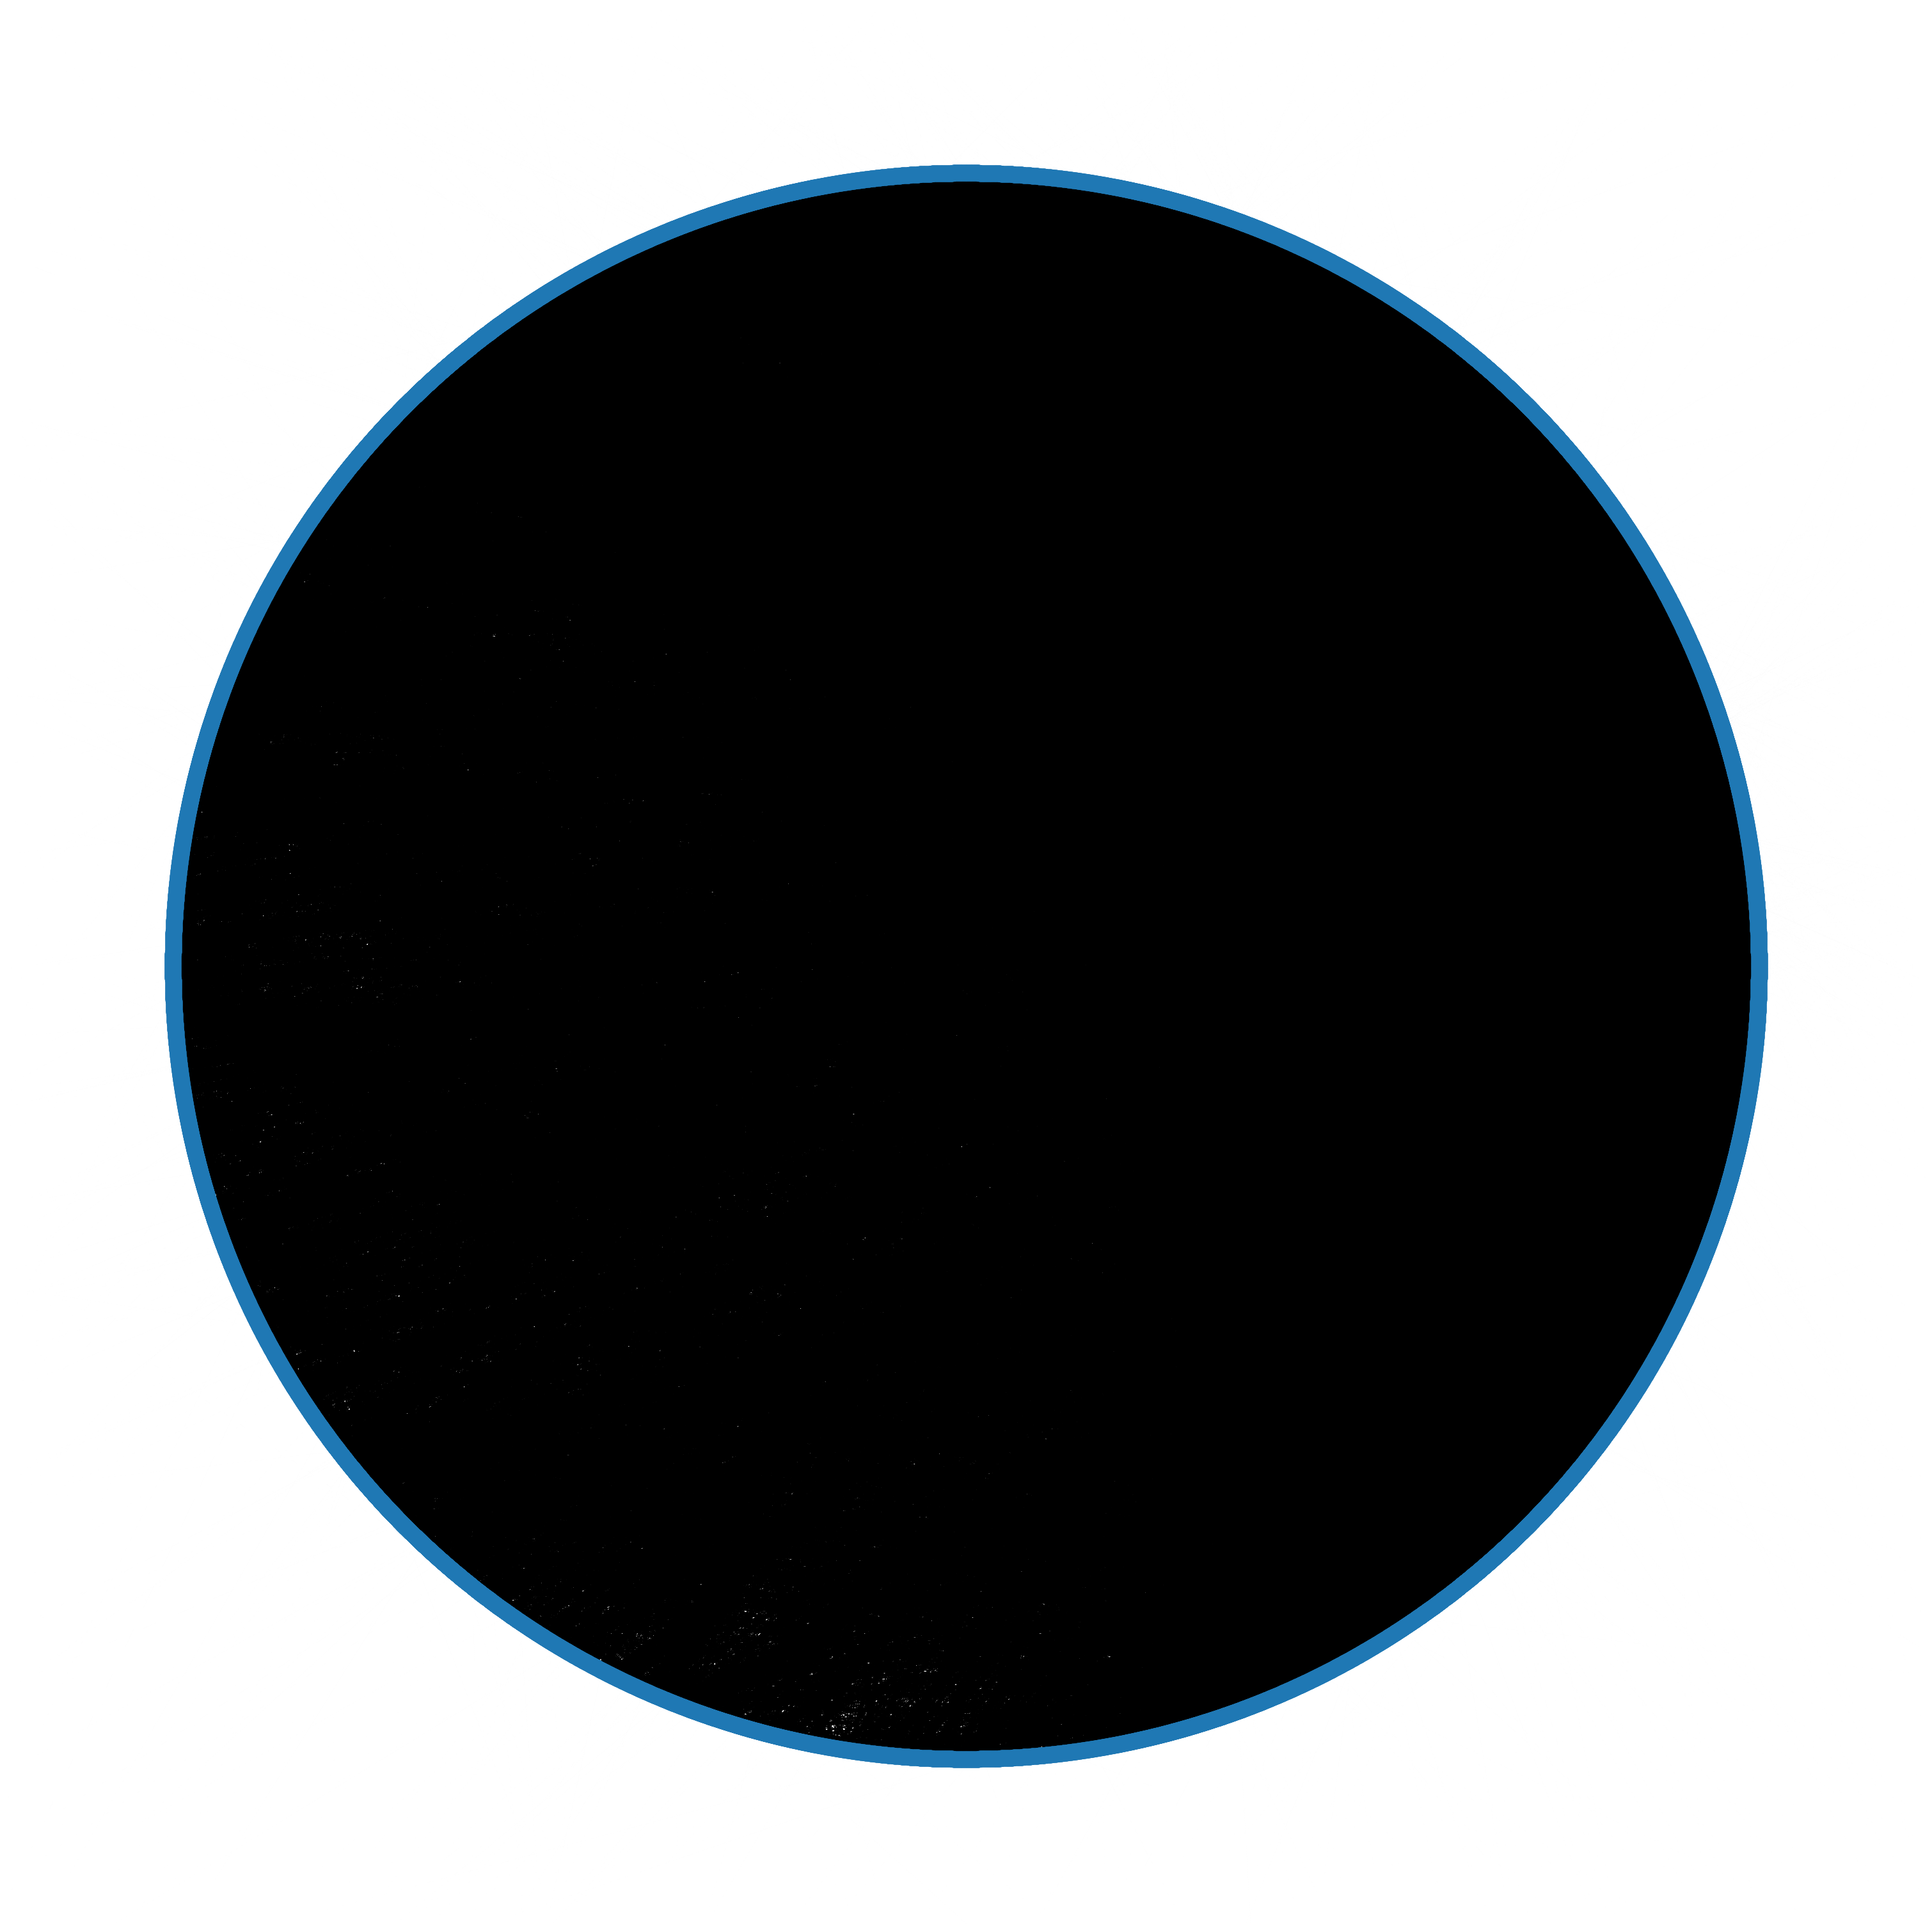

In [27]:
pos = nx.circular_layout(pygraph)

plt.figure(3, figsize=(30, 30))
nx.draw(pygraph, pos)
plt.show()

## Exporting graph to external resources or databases

#### Cytoscape

In [ ]:
from pyBiodatafuse.graph import cytoscape

cytoscape.load_graph(pygraph, network_name="PCS network")

#### Neo4j

In [28]:
from pyBiodatafuse.graph import neo4j

neo4j.save_graph_to_graphml(
    pygraph,
    output_path=os.path.join(
        os.getcwd(), "examples", "usecases", "PCS", "pcs_networkx_graph.graphml"
    ),
)

##### Steps to load the graph in Neo4j

- Add `.graphml` file in **import** subfolder of the DBMS folder
- Install apoc plugin
- Create `apoc.conf` file:
    ```
    apoc.trigger.enabled=true
    apoc.import.file.enabled=true
    apoc.export.file.enabled=true
    apoc.import.file.use_neo4j_config=true
    ```
- Add `apoc.conf` file to **conf** subfolder of the DBMS folder
- Open Neo4j Browser
- (Optionl, only run if you have imported a graph before) Remove all the nodes before importing `.graphml` file

    ```
    MATCH (n) DETACH DELETE n
    ```

- Import `.graphml` file

    ```
    call apoc.import.graphml('file:///pcs_networkx_graph.graphml',{readLabels:TRUE})
    ```

- Add indexes after importing the graph for improving the performance of queries

    ```
    create index Gene for (n:Gene) on (n.node_type)
    create index Pathway for (n:Pathway) on (n.node_type)
    create index `Biological Process` for (n:`Biological Process`) on (n.node_type)
    create index `Molecular Function` for (n:`Molecular Function`) on (n.node_type)
    create index `Cellular Component` for (n:`Cellular Component`) on (n.node_type)
    create index Disease for (n:Disease) on (n.node_type)
    create index Compound for (n:Compound) on (n.node_type)
    create index `Side Effect` for (n:`Side Effect`) on (n.node_type)
    ```

- Count the number of each node type
    - total (```MATCH (n) RETURN count(n)```) = 19860
        - Gene (```c```) = 1667
        - Pathway (```MATCH (n:Pathway) RETURN count(n)```) = 1847
            - WikiPathways (```MATCH (n:Pathway {source: "WikiPathways"}) RETURN count(n)```) = 678
            - OpenTargets, Reactome (```MATCH (n:Pathway {source: "OpenTargets"}) RETURN count(n)```) = 1154
            - MINERVA (```MATCH (n:Pathway {source: "MINERVA"}) RETURN count(n)```) = 15
        - Biological Process (```MATCH (n:`Biological Process`) RETURN count(n)```) = 4624
        - Molecular Function (```MATCH (n:`Molecular Function`) RETURN count(n)```) = 1327
        - Cellular Component (```MATCH (n:`Cellular Component`) RETURN count(n)```) = 736
        - Disease (```MATCH (n:Disease) RETURN count(n)```) = 2914
            - DISGENET (```MATCH (n:Disease {source: "DISGENET"}) RETURN count(n)```) = 2913
            - Literature (```MATCH (n:Disease {source: "PMID: 37675861"}) RETURN count(n)```) = 1
        - Compound (```MATCH (n:Compound) RETURN count(n)```) = 2244
        - Side Effect (```MATCH (n:`Side Effect`) RETURN count(n)```) = 4501
- Count the number of each edge type
    - total (```MATCH ()-[r]->() RETURN count(r)```) = 101659
        - interacts_with (```MATCH ()-[r:interacts_with]->() RETURN count(r)```) = 16844
        - part_of (```MATCH ()-[r:part_of]->() RETURN count(r)```) = 30066 
            - WikiPathways (```MATCH ()-[r:part_of {source: "WikiPathways"}]->() RETURN count(r)```) = 3174
            - OpenTargets, Reactome (```MATCH ()-[r:part_of {source: "OpenTargets"}]->() RETURN count(r)```) = 26784
            - MINERVA (```MATCH ()-[r:part_of {source: "MINERVA"}]->() RETURN count(r)```) = 108
        - activates (```MATCH ()-[r:activates]->() RETURN count(r)```) = 499
        - treats (```MATCH ()-[r:treats]->() RETURN count(r)```) = 8215
        - has_side_effect (```MATCH ()-[r:has_side_effect]->() RETURN count(r)```) = 38328
        - inhibits (```MATCH ()-[r:inhibits]->() RETURN count(r)```) = 71
        - associated_with (```MATCH ()-[r:associated_with]->() RETURN count(r)```) = 7636
            - Literature (```MATCH ()-[r:associated_with {source: "DISGENET"}]->() RETURN count(r)```) = 7607
            - DISGENET (```MATCH ()-[r:associated_with{source: "PMID: 37675861"}]->() RETURN count(r)```) = 29

- Export the graph as a `.csv` file

    ```call apoc.export.csv.all("pcs_networkx_graph.csv",{})```